### Task 2.1

In [ ]:
%%capture
!pip install dynamiqs

In [ ]:
import dynamiqs as dq
import jax
import jax.numpy as jnp
from scipy import constants
import matplotlib.pyplot as plt

In [ ]:
# Parameters (converted to angular frequencies)
omega_a = 5.26 * 2 * jnp.pi  # GHz to rad/μs
omega_b = 7.70 * 2 * jnp.pi
phi_a = 0.06
phi_b = 0.29
E_J = 12.03 * 2 * constants.h
Delta_E_J = 0.47 * 2 * constants.h
omega_d = 7.623 * 2 * jnp.pi
omega_p = 2.891 * 2 * jnp.pi
epsilon_d = -3.815 * 1e-3 * 2 * jnp.pi  # MHz to rad/μs
epsilon_p = 0.122  # rad

In [ ]:
T = 4.0 # μs (longer to observe dynamics)
num_steps = 2000  # Increase resolution
tsave = jnp.linspace(0, T, num_steps)

# Hilbert space dimensions
N_a = 20  # Mode a truncation
N_b = 5   # Mode b truncation

# Quantum operators
a = dq.tensor(dq.destroy(N_a), dq.eye(N_b))
b = dq.tensor(dq.eye(N_a), dq.destroy(N_b))
a_dag = dq.tensor(dq.destroy(N_a).dag(), dq.eye(N_b))
b_dag = dq.tensor(dq.eye(N_a), dq.destroy(N_b).dag())

# Time-dependent ATS Hamiltonian
def H_total(t):
    t_scaled = t * 1e-6  # Convert from μs to seconds if needed

    # Static Hamiltonian
    H0 = (
        omega_a * (a_dag @ a) +
        omega_b * (b_dag @ b)
    )

    eps_t = epsilon_p * jnp.cos(omega_p * t_scaled)

    # Construct phi_hat
    phi_op = (
        phi_a * (a + a_dag) +
        phi_b * (b + b_dag)
    )

    # Compute trigonometric terms
    phi_jax = dq.to_jax(phi_op)
    sin_term = dq.asqarray(jnp.sin(phi_jax), (N_a, N_b))
    cos_term = dq.asqarray(jnp.cos(phi_jax), (N_a, N_b))

    H_ATS = (
        -2 * E_J * jnp.sin(eps_t) * sin_term +
        2 * Delta_E_J * jnp.cos(eps_t) * cos_term
    )

    # **Increase drive amplitude**
    epsilon_d_strong = 5 * epsilon_d  # 5x drive strength to induce evolution
    drive_term = 2 * epsilon_d_strong * jnp.cos(omega_d * t_scaled)
    H_d = drive_term * (b + b_dag)

    return dq.asqarray(H0 + H_ATS + H_d)

# Convert to TimeQarray
H_total_tq = dq.timecallable(H_total)

# Dissipation operators
kappa_a = 9.3 * omega_a / (2 * jnp.pi)
kappa_b = 2.6 * omega_b / (2 * jnp.pi)
L_a = jnp.sqrt(kappa_a) * a
L_b = jnp.sqrt(kappa_b) * b

# Initial state
rho0 = dq.tensor(dq.fock_dm(N_a, 0), dq.fock_dm(N_b, 0))

# Solve the master equation
result = dq.mesolve(H_total_tq, [L_a, L_b], rho0, tsave)

<ipython-input-19-048045d44316>:48: UserWarning: A sparse qarray has been converted to dense layout due to element-wise addition with a dense qarray.
  return dq.asqarray(H0 + H_ATS + H_d)
/usr/local/lib/python3.11/dist-packages/dynamiqs/qarrays/qarray.py:481: UserWarning: A sparse qarray has been converted to dense layout due to element-wise addition with a dense qarray.
  return self.__add__(y)
|██████████| 100.0% ◆ elapsed 2.21s ◆ remaining 0.00ms


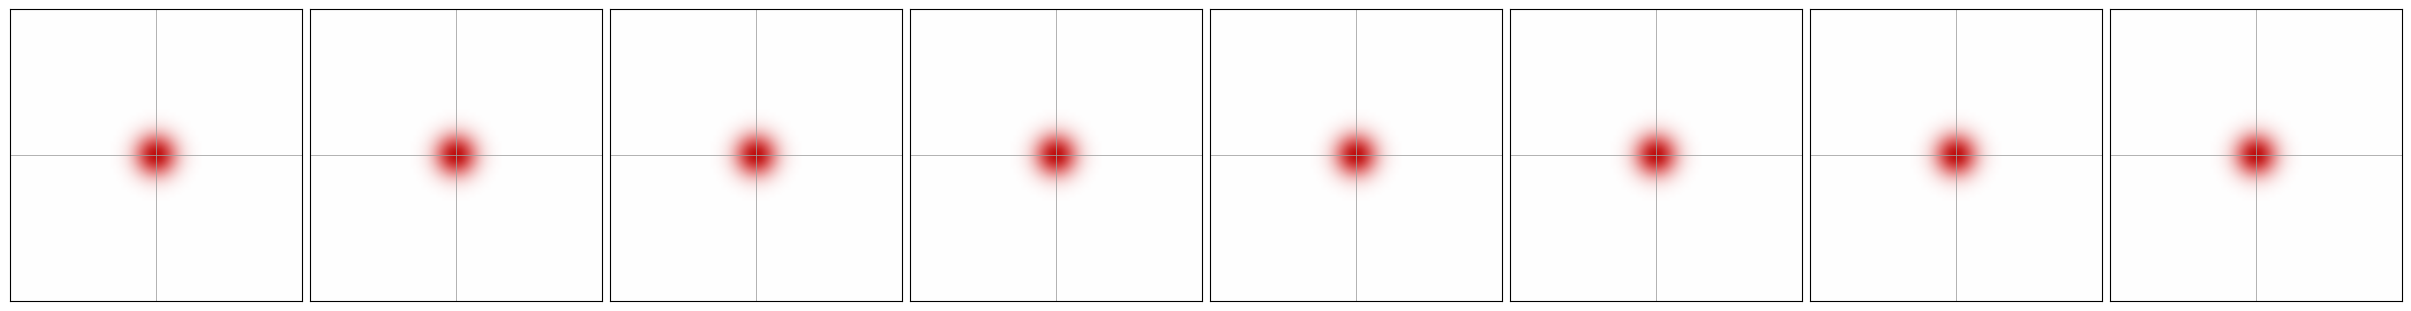

In [ ]:
dq.plot.wigner_mosaic(dq.ptrace(result.states, 0, (N_a, N_b)), cross = True)

100%|██████████| 50/50 [00:08<00:00,  5.97it/s]


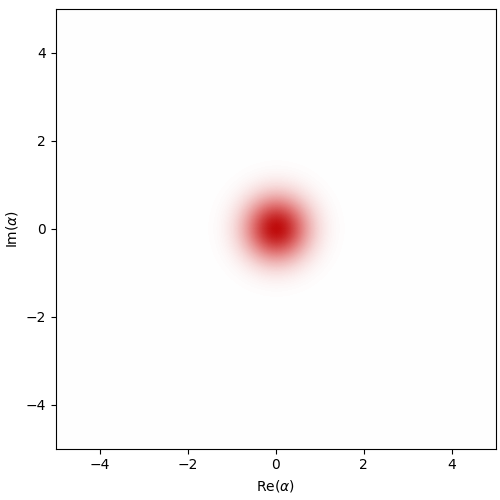

In [ ]:
dq.plot.wigner_gif(dq.ptrace(result.states, 0, (N_a, N_b)), gif_duration=2, fps=25)

### Task 2.2

In [ ]:

# Parameters (same as before, with detuning considered)
omega_0 = 1.0  # Eigenfrequency of mode a (rad/s)
omega_d = 1.0  # Drive frequency (rad/s)
epsilon = 1.0  # Drive strength
T = 4.0  # μs (observation time)
num_steps = 2000  # Increase resolution
tsave = jnp.linspace(0, T, num_steps)

# Hilbert space dimensions
N_a = 20  # Mode a truncation

# Quantum operators
a = dq.destroy(N_a)
a_dag = a.dag()

# Time-dependent ATS Hamiltonian (including drive)
def H_total(t):
    # Static Hamiltonian
    H0 = omega_0 * a_dag @ a

    # Time-dependent term (drive)
    eps_t = epsilon * jnp.cos(omega_d * t)
    H_drive = eps_t * (a_dag + a)

    return H0 + H_drive

# Define the unitary rotation (rotating frame)
def R_a(t, omega_d):
    return dq.expm(-1j * omega_d * a_dag @ a * t)

# Apply the rotating frame transformation to the Hamiltonian
def H_rot_frame(t):
    # Hamiltonian in the rotating frame
    H_rot = R_a(t, omega_d) @ H_total(t) @ R_a(t, omega_d).dag()

    # Detuning term (no explicit time-dependence after the transformation)
    detuning = omega_0 - omega_d
    H_rot_simplified = detuning * a_dag @ a + epsilon * (a_dag + a)

    return dq.asqarray(H_rot_simplified)

# Convert to TimeQarray
H_rot_tq = dq.timecallable(H_rot_frame)

# Dissipation operator (single-photon loss for mode a)
kappa_a = 9.3 * omega_0 / (2 * jnp.pi)  # Adjust according to your system
L_a = jnp.sqrt(kappa_a) * a

# Initial state (vacuum state for mode a)
rho0 = dq.fock_dm(N_a, 0)

# Solve the master equation in the rotating frame
result_rot = dq.mesolve(H_rot_tq, [L_a], rho0, tsave)

/usr/local/lib/python3.11/dist-packages/equinox/_module.py:1096: UserWarning: A `SparseDIAQArray` has been converted to a `DenseQArray` while computing its matrix exponential.
  return self.__func__(self.__self__, *args, **kwargs)
|██████████| 100.0% ◆ elapsed 91.95ms ◆ remaining 0.00ms


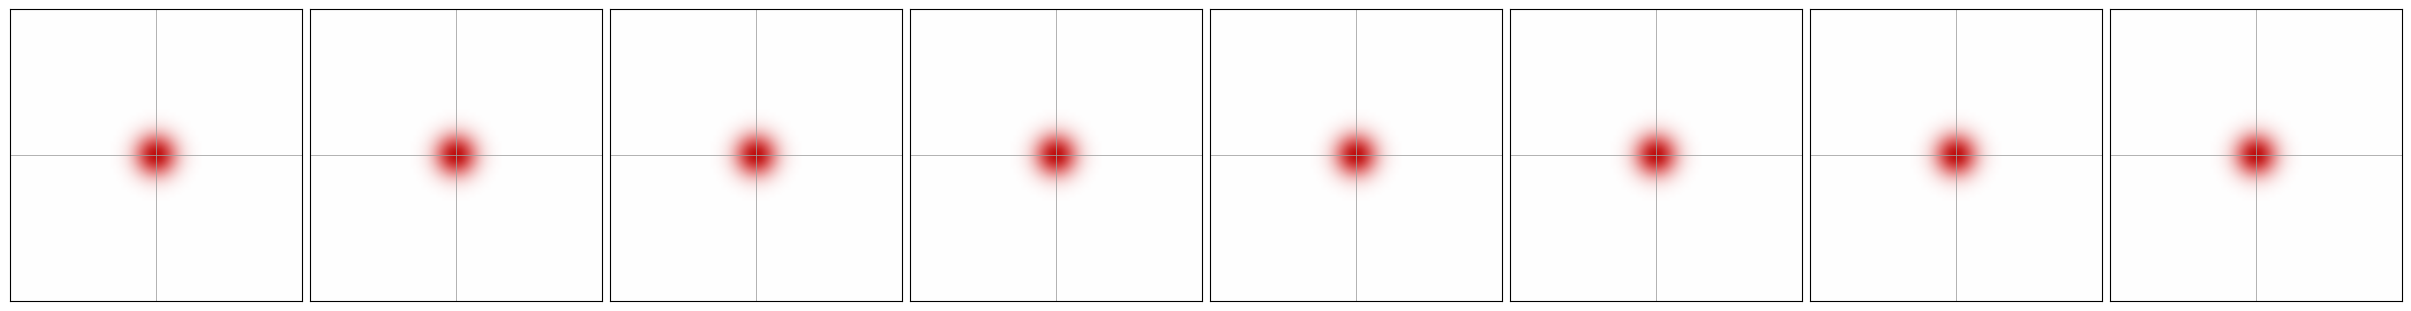

In [ ]:
dq.plot.wigner_mosaic(dq.ptrace(result.states, 0, (N_a, N_b)), cross = True)

100%|██████████| 50/50 [00:08<00:00,  6.06it/s]


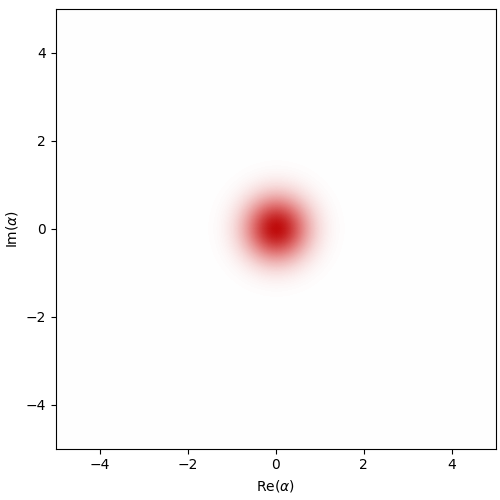

In [ ]:
dq.plot.wigner_gif(dq.ptrace(result.states, 0, (N_a, N_b)), gif_duration=2, fps=25)